In [4]:
import sys
import numpy as np
import pandas as pd
from scipy import stats

# === Налаштування користувача ===
file_path = r"C:\Users\slavi\Downloads\ts (1).csv" 
series_idx = 1 # 1 → перший ряд даних (X1), 2 → другий (X2)
max_degree = 3
alpha = 0.05

# === 1. Зчитування даних із заголовками ===
try:
    df = pd.read_csv(file_path)  # header=0 за замовчуванням
except FileNotFoundError:
    print(f"Не знайдено файл за шляхом {file_path}")
    sys.exit(1)

print("Стовпці:", df.columns.tolist())

# === 2. Вибір t та y ===
t = df['t'].astype(float).values
y = df.iloc[:, series_idx].astype(float).values
N = len(y)

# === 3. Функція автокореляції лаг 1 ===
def acf_lag1(x):
    arr = np.asarray(x, float).flatten()
    c = arr - arr.mean()
    return np.sum(c[:-1] * c[1:]) / np.sum(c**2)

# === 4. Пошук степеня полінома тренда ===
for d in range(max_degree+1):
    y_diff = np.diff(y, n=d) if d>0 else y
    r1 = acf_lag1(y_diff)
    crit = 1.96 / np.sqrt(len(y_diff))
    print(f"Degree {d}: acf₁ = {r1:.4f}, threshold = ±{crit:.4f}")
    if abs(r1) < crit:
        p = d
        break
else:
    p = max_degree

print(f"\n=> Обраний степінь полінома: p = {p}\n")

# === 5. Оцінка полінома тренда МНК ===
X = np.vstack([t**k for k in range(p+1)]).T
theta_hat = np.linalg.inv(X.T @ X) @ X.T @ y
f_hat = X @ theta_hat
residuals = y - f_hat

print("Коефіцієнти θ̂:", np.round(theta_hat, 4))

# === 6. Критерій серій за медіаною ===
med = np.median(residuals)
signs = np.where(residuals - med > 0, 1, -1)
runs = np.sum(signs[1:] != signs[:-1]) + 1
idx = np.where(np.concatenate(([True], signs[1:]!=signs[:-1], [True])))[0]
longest = np.max(np.diff(idx) - 1)
Er = 1 + (N-1)
Vr = (4*N - 6)/4
z_runs = (runs - Er) / np.sqrt(Vr)

print("\n=== Серії за медіаною ===")
print(f"Серії: {runs}, Z = {z_runs:.3f}, найдовша = {longest}")
print("H0 " + ("не відхиляється" if abs(z_runs)<stats.norm.ppf(1-alpha/2) else "відхиляється"))

# === 7. Критерій висхідних/низхідних серій ===
diff = residuals[1:] - residuals[:-1]
diff = diff[diff != 0]
asc = np.where(diff > 0, 1, -1)
runs2 = np.sum(asc[1:] != asc[:-1]) + 1
idx2 = np.where(np.concatenate(([True], asc[1:]!=asc[:-1], [True])))[0]
long2 = np.max(np.diff(idx2) - 1)
Er2 = (2*len(asc)-1)/3
Vr2 = (16*len(asc)-29)/90
z2 = (runs2 - Er2) / np.sqrt(Vr2)

print("\n=== Висхідно/низхідні серії ===")
print(f"Серії: {runs2}, Z = {z2:.3f}, найдовша = {long2}")
print("H0 " + ("не відхиляється" if abs(z2)<stats.norm.ppf(1-alpha/2) else "відхиляється"))

# === 8. Висновки ===
print(f"""
--- Висновки (стовпець #{series_idx}) ---
1) Поліном ступеня {p}, θ̂ = {np.round(theta_hat,4)}.
2) Серій за медіаною: H0 {'не відхиляється' if abs(z_runs)<stats.norm.ppf(1-alpha/2) else 'відхиляється'}.
3) Висхідно/низхідних серій: H0 {'не відхиляється' if abs(z2)<stats.norm.ppf(1-alpha/2) else 'відхиляється'}.
""")


Стовпці: ['t', 'X1 (пол.2 + шум)', 'X2 (пол.3 + шум)']
Degree 0: acf₁ = 0.6831, threshold = ±0.2772
Degree 1: acf₁ = -0.3818, threshold = ±0.2800
Degree 2: acf₁ = -0.6932, threshold = ±0.2829
Degree 3: acf₁ = -0.7961, threshold = ±0.2859

=> Обраний степінь полінома: p = 3

Коефіцієнти θ̂: [ 2.463   0.4257 -0.0065 -0.    ]

=== Серії за медіаною ===
Серії: 22, Z = -4.021, найдовша = 6
H0 відхиляється

=== Висхідно/низхідні серії ===
Серії: 36, Z = 1.266, найдовша = 3
H0 не відхиляється

--- Висновки (стовпець #1) ---
1) Поліном ступеня 3, θ̂ = [ 2.463   0.4257 -0.0065 -0.    ].
2) Серій за медіаною: H0 відхиляється.
3) Висхідно/низхідних серій: H0 не відхиляється.



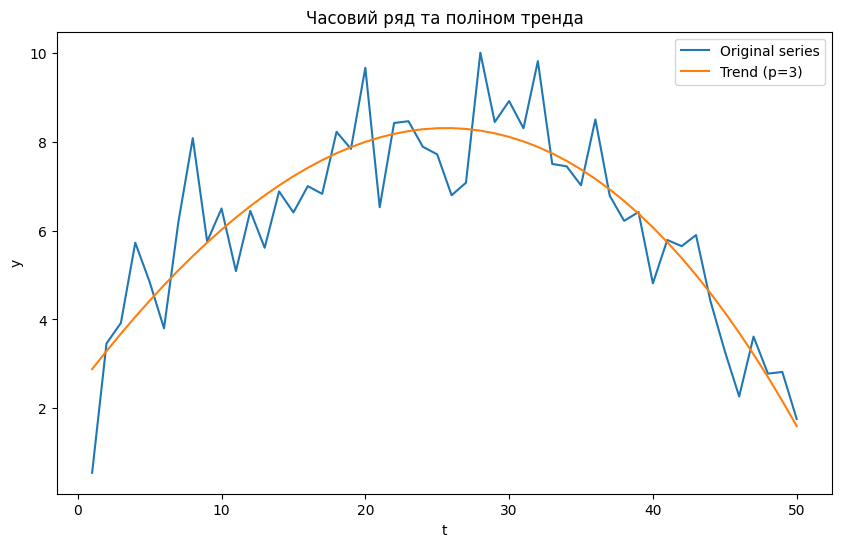

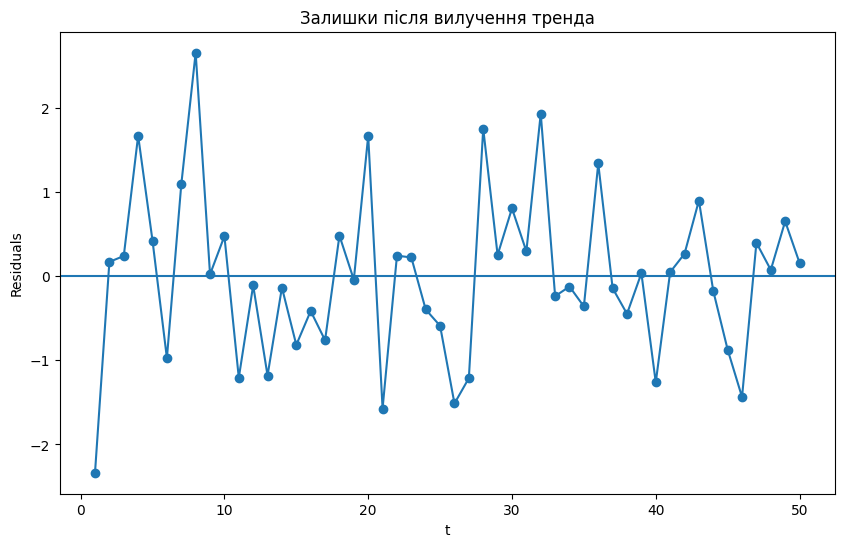

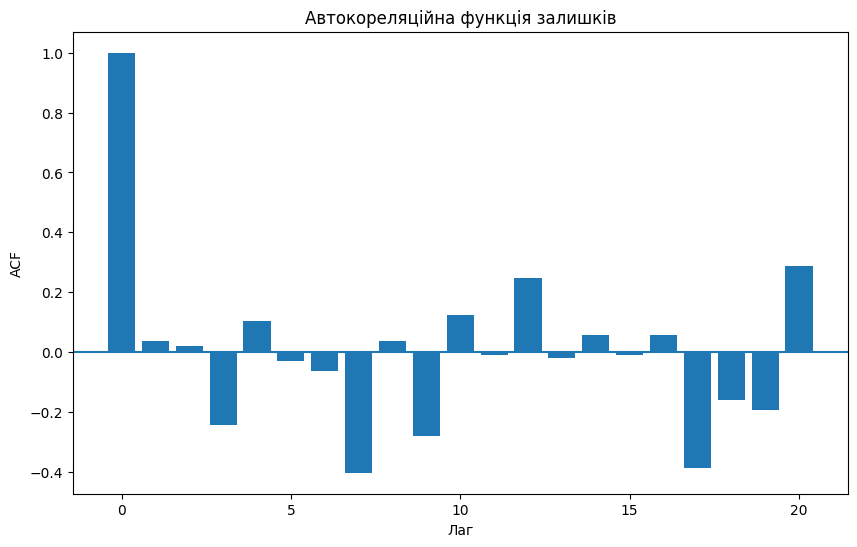

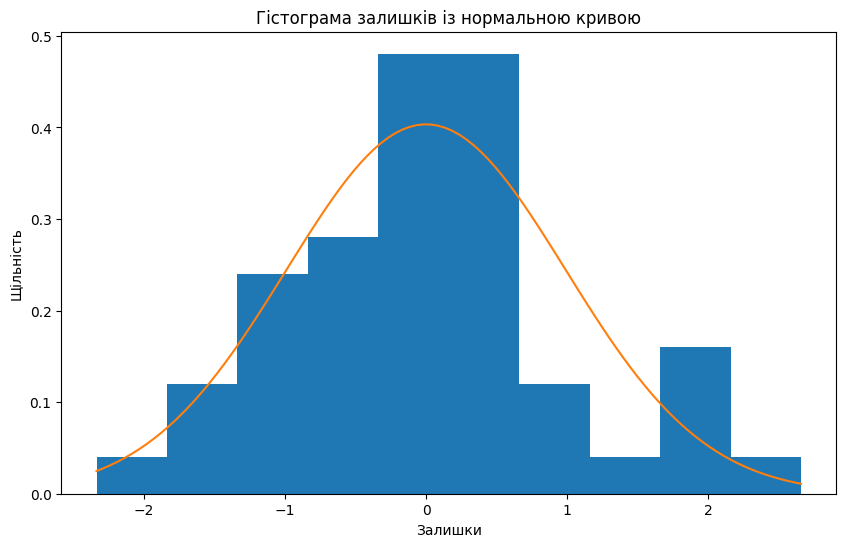

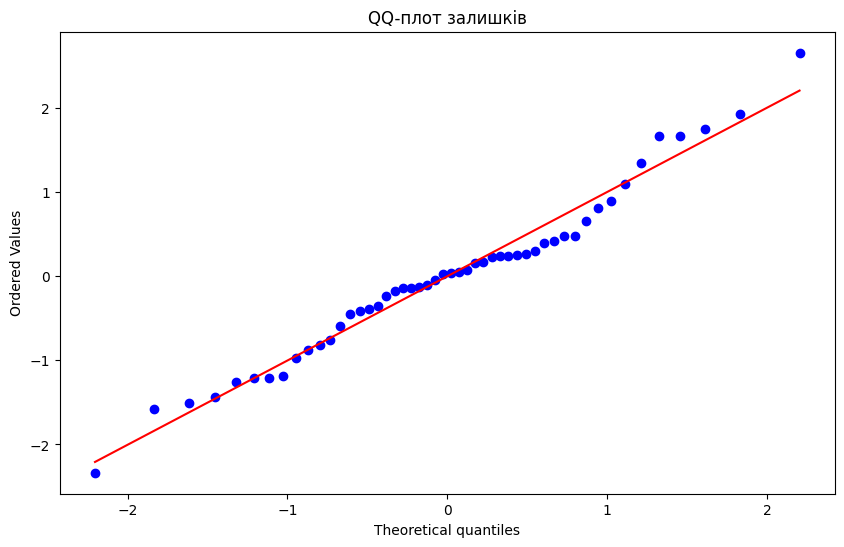

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# === Налаштування ===
file_path_local = r"C:\Users\slavi\Downloads\ts.csv"
series_idx = 1  # 1 → X1, 2 → X2
max_degree = 3
alpha = 0.05

# === Зчитування даних ===
df = pd.read_csv(file_path_local)

# Підготовка
t = df['t'].astype(float).values
y = df.iloc[:, series_idx].astype(float).values

# Функція автокореляції лаг 1
def acf_lag1(x):
    arr = np.asarray(x, float).flatten()
    c = arr - arr.mean()
    return np.sum(c[:-1] * c[1:]) / np.sum(c**2)

# Визначення степеня полінома тренда
for d in range(max_degree + 1):
    y_diff = np.diff(y, n=d) if d > 0 else y
    if abs(acf_lag1(y_diff)) < 1.96 / np.sqrt(len(y_diff)):
        p = d
        break
else:
    p = max_degree

# Оцінка полінома тренда та залишки
X = np.vstack([t**k for k in range(p+1)]).T
theta_hat = np.linalg.inv(X.T @ X) @ X.T @ y
f_hat = X @ theta_hat
residuals = y - f_hat

# === Візуалізації ===
plt.figure(figsize=(10, 6))
plt.plot(t, y, label='Original series')
plt.plot(t, f_hat, label=f'Trend (p={p})')
plt.title('Часовий ряд та поліном тренда')
plt.xlabel('t')
plt.ylabel('y')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(t, residuals, marker='o')
plt.axhline(0)
plt.title('Залишки після вилучення тренда')
plt.xlabel('t')
plt.ylabel('Residuals')
plt.show()

# ACF
lags = np.arange(0, 21)
acf_vals = [1.0] + [np.corrcoef(residuals[:-lag], residuals[lag:])[0,1] for lag in range(1, 21)]
plt.figure(figsize=(10, 6))
plt.bar(lags, acf_vals)
plt.axhline(0)
plt.title('Автокореляційна функція залишків')
plt.xlabel('Лаг')
plt.ylabel('ACF')
plt.show()

# Гістограма з нормальною кривою
mu, sigma = residuals.mean(), residuals.std(ddof=1)
plt.figure(figsize=(10, 6))
count, bins, _ = plt.hist(residuals, bins=10, density=True)
x = np.linspace(bins.min(), bins.max(), 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.title('Гістограма залишків із нормальною кривою')
plt.xlabel('Залишки')
plt.ylabel('Щільність')
plt.show()

# QQ-плот
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('QQ-плот залишків')
plt.show()